# Statistical Analysis of the Titanic Dataset with AGENT

## Introduction

This notebook provides an overview of conducting various statistical analyses on the Titanic dataset using pandas in conjunction with Antigranular Enterprise (AGENT). Through this tutorial, you'll learn how to prepare, analyze, and visualize data while ensuring privacy compliance. The Titanic dataset, which contains information on the passengers aboard the ill-fated ship, serves as our example dataset for these exercises. We can consider it old-school PII data!

## Setting Up

First, ensure you have pandas, seaborn, and Antigranular Enterprise installed in your environment. We'll use seaborn to load the Titanic dataset and pandas for our data manipulation needs. Add your AGENT import statements here.

In [ ]:
!pip install antigranular_enterprise -U 1> /dev/null 2> /dev/null
import antigranular_enterprise as ag
import seaborn as sns
import pandas as pd

titanic = sns.load_dataset('titanic')

# These details will be used going forward, you can have and toggle between multiple profiles
ag.write_config(profile='default', yaml_config="""
AGENT_JUPYTER_URL: https://agent.antigranular.com
AGENT_JUPYTER_PORT: 443
AGENT_CONSOLE_URL: http://agent-api-dev.antigranular.com
""")

# Connect in via your API key
ag.read_config("default")
session = ag.login(api_key="<api_key>")

Your request is pending approval. Please visit the following URL to approve the request: http://agent-dev.antigranular.com
Request approved.
Connected to Antigranular server session id: 306b049b-1138-4118-8cc2-335cd0867ec8
Cell magic '%%ag' registered successfully, use `%%ag` in a notebook cell to execute your python code on Antigranular private python server


## Importing the Dataset with Privacy in Mind

Use AGENT to securely import the Titanic dataset. This step ensures that our data analysis adheres to privacy-preserving protocols from the outset.

In [ ]:
# We will first upload the DataFrame and then make it a PrivateDataFrame
session.private_import(titanic, "titanic")

dataframe cached to server, loading to kernel...
DataFrame loaded successfully to the kernel



In [ ]:
%%ag
# import the Oblivious Python (op_) Pandas Package
import op_pandas as opd

titanic = opd.PrivateDataFrame(
    titanic,
    # metadata are the bound on numerical data
    metadata={
        "survived": (0, 1),
        "pclass": (1, 3),
        "age": (0, 100),
        "sibsp": (0, 8),
        "parch": (0, 6),
        "fare": (0, 515)
    },
    # categorical_metadata are Literal values of non-numeric columns
    # str in general don't need these, but often a column will not support
    # all strs
    categorical_metadata={
        "sex": ['male', 'female'],
        "who": ['man', 'woman', 'child'],
        "embark_town": ['Southampton', 'Cherbourg', 'Queenstown'],
        "deck": ['A', 'B', 'C', 'D', 'E', 'F', 'G'],
        "class": ['First', 'Second', 'Third'],
        "alive": ['yes', 'no']
    }
  )

## Exploratory Data Analysis (EDA)

Understanding your dataset is crucial before diving into deeper analysis. Use pandas and op_pandas for a preliminary examination and compare their outputs to build your intuition.

### Dataset Summary

![](https://img.shields.io/static/v1?style=for-the-badge&message=Regular%20Python&color=FFFFB0&logo=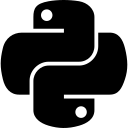&label=)

In [ ]:
# This is you local pandas computing the exact describe
local_describe = titanic.describe()
local_describe

,survived,pclass,age,sibsp,parch,fare
count,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


![](https://img.shields.io/static/v1?style=for-the-badge&message=Antigranular%20Python&color=000000&logo=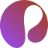&label=)

In [ ]:
%%ag
# This is the equivilent op_pandas computing the DP describe
describe = titanic.describe(eps=1)

export(describe, "ag_describe")

Setting up exported variable in local environment: ag_describe


In [ ]:
ag_describe

,survived,pclass,age,sibsp,parch,fare
count,726.000000,883.000000,654.000000,918.000000,880.000000,889.000000
mean,0.341307,2.391599,34.465826,0.000000,0.538547,61.302541
std,0.386220,0.585280,25.343122,0.748045,2.019754,119.199233
min,0.000000,1.000000,0.000000,0.000000,0.000000,6.564492
25%,0.017074,1.272932,21.697964,0.578755,0.540184,9.927072
50%,0.402345,2.899859,26.600788,1.583172,0.163200,22.887489
75%,0.999836,1.452100,39.671030,0.014459,1.097541,124.090064
max,0.595424,2.962501,79.453234,7.901352,1.799843,376.515850


We can more neatly compare these side-by-side by merging their outputs into a single table:

In [ ]:
import pandas as pd
import numpy as np

def compare_describe(desc1, desc2):
  # Manually construct a new DataFrame
  combined_stats = pd.DataFrame()
  combined_stats.index.name = f'True | ε-DP'

  for col in desc1.columns:
      for index in desc1.index:
          val1 = desc1.at[index, col]
          val2 = desc2.at[index, col]
          combined_stats.at[index, col] = f"{val1} | {val2}"

  return combined_stats

# Compare descriptive statistics
compare_describe(local_describe.round(2), ag_describe.round(2))

,survived,pclass,age,sibsp,parch,fare
True | ε-DP,,,,,,
count,891.0 | 726.0,891.0 | 883.0,714.0 | 654.0,891.0 | 918.0,891.0 | 880.0,891.0 | 889.0
mean,0.38 | 0.34,2.31 | 2.39,29.7 | 34.47,0.52 | 0.0,0.38 | 0.54,32.2 | 61.3
std,0.49 | 0.39,0.84 | 0.59,14.53 | 25.34,1.1 | 0.75,0.81 | 2.02,49.69 | 119.2
min,0.0 | 0.0,1.0 | 1.0,0.42 | 0.0,0.0 | 0.0,0.0 | 0.0,0.0 | 6.56
25%,0.0 | 0.02,2.0 | 1.27,20.12 | 21.7,0.0 | 0.58,0.0 | 0.54,7.91 | 9.93
50%,0.0 | 0.4,3.0 | 2.9,28.0 | 26.6,0.0 | 1.58,0.0 | 0.16,14.45 | 22.89
75%,1.0 | 1.0,3.0 | 1.45,38.0 | 39.67,1.0 | 0.01,0.0 | 1.1,31.0 | 124.09
max,1.0 | 0.6,3.0 | 2.96,80.0 | 79.45,8.0 | 7.9,6.0 | 1.8,512.33 | 376.52


### Missing Values

We can also check out how many records contain a null value. This is helpful for us to consider if we will need to impute the dataset in some way.

![](https://img.shields.io/static/v1?style=for-the-badge&message=Regular%20Python&color=FFFFB0&logo=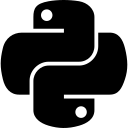&label=)

In [ ]:
# Locally we can sum the isnull sum
print(titanic.isnull().sum())

survived         0
pclass           0
sex              0
age            177
sibsp            0
parch            0
fare             0
embarked         2
class            0
who              0
adult_male       0
deck           688
embark_town      2
alive            0
alone            0
dtype: int64


![](https://img.shields.io/static/v1?style=for-the-badge&message=Antigranular%20Python&color=000000&logo=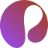&label=)

In [ ]:
%%ag
# We can do the same from AGENT by modifying the print and adding the eps to spend
ag_print(titanic.isnull().sum(eps=0.1))

survived        22.244355
pclass          22.441848
sex              0.000000
age            187.804589
sibsp            0.000000
parch           15.176939
fare            26.412467
embarked         0.000000
class            2.117769
who             23.529391
adult_male       4.232583
deck           645.491622
embark_town      0.000000
alive            0.000000
alone            0.000000
dtype: float64



## Data Cleaning and Preparation

Address missing values and prepare your dataset for analysis. This might involve filling in missing values or dropping rows/columns.

![](https://img.shields.io/static/v1?style=for-the-badge&message=Regular%20Python&color=FFFFB0&logo=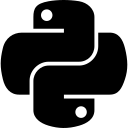&label=)

In [ ]:
# Example: Fill missing age values with the median age
titanic['age'].fillna(titanic['age'].median(), inplace=True)

![](https://img.shields.io/static/v1?style=for-the-badge&message=Antigranular%20Python&color=000000&logo=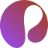&label=)

In [ ]:
%%ag
# The same example in AGENT with epsilon spend
titanic['age'].fillna(titanic['age'].median(eps = 0.1), inplace=True)

## Descriptive Statistics

Gain insights into the central tendency and dispersion of your data.

![](https://img.shields.io/static/v1?style=for-the-badge&message=Regular%20Python&color=FFFFB0&logo=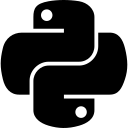&label=)

In [ ]:
print(titanic['age'].mean())
print(titanic['age'].std())

29.36158249158249
13.019696550973201


![](https://img.shields.io/static/v1?style=for-the-badge&message=Antigranular%20Python&color=000000&logo=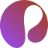&label=)

In [ ]:
%%ag
# almost the exact same, but with eps and ag_print
ag_print(titanic['age'].mean(eps=0.1))
ag_print(titanic['age'].std(eps=0.1))

29.726334401935095

9.676073136597735



## Grouped Analyses

Deep dive into specific segments of your dataset.

![](https://img.shields.io/static/v1?style=for-the-badge&message=Regular%20Python&color=FFFFB0&logo=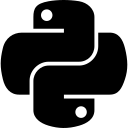&label=)

In [ ]:
print(titanic.groupby('class')['survived'].mean())

class
First     0.629630
Second    0.472826
Third     0.242363
Name: survived, dtype: float64


![](https://img.shields.io/static/v1?style=for-the-badge&message=Antigranular%20Python&color=000000&logo=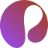&label=)

In [ ]:
%%ag
ag_print(titanic.groupby('class')['survived'].mean(eps=0.1))

               0
First   0.583770
Second  0.493154
Third   0.195803

